#Demo de TF-Agents para ejemplo del Mono que quiere Banana usando primero Q-Learning y luego una red DQN
 Basado inicialmente en los tutoriales de Tensor Flow: https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial
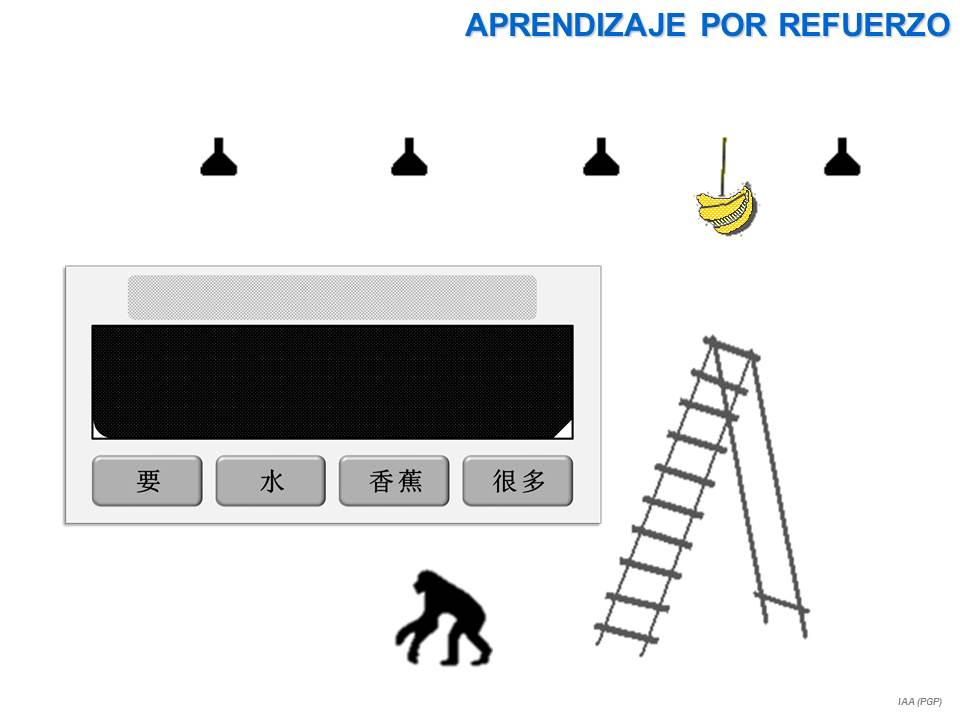

In [1]:
#@title Instalar Paquete de TF-Agents
# usar esta versión para evitar errores
# recomendada en https://github.com/tensorflow/agents
!pip install tf-agents[reverb]
!git clone https://github.com/tensorflow/agents.git
!cd agents
#!git checkout v0.15.0  
print("TF-Agentes instalado.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 KB 23.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 KB 1.9 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697657 sha256=7c3c63bd71e750e72544a9df78793ab992dc7596a6873af9caaadb7946f5871a
  Stored in directory: /root/.cache/pip/wheels/96/b9/bb/994c1324b65e39dd1cd7b8ba92e5fb766dd77980929414a866
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling g

In [2]:
#@title Cargar Librerías

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
from random import randint
import pandas as pd


import reverb
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import time_step as ts

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents import CategoricalDqnAgent
from tf_agents.networks import q_network, categorical_q_network
from tf_agents.utils import common

from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

from tf_agents.networks import sequential
from tf_agents.specs import tensor_spec
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.drivers import py_driver
from tf_agents.policies import py_tf_eager_policy

tf.compat.v1.enable_v2_behavior()

print("Librerías cargadas.")
print("(nota: ignorar el error que tira por diferencias de versiones)")

RuntimeError: ignored

Librerías cargadas.
(nota: ignorar el error que tira por diferencias de versiones)


## Clases sobre el Problema a resolver

Entorno del Problema:

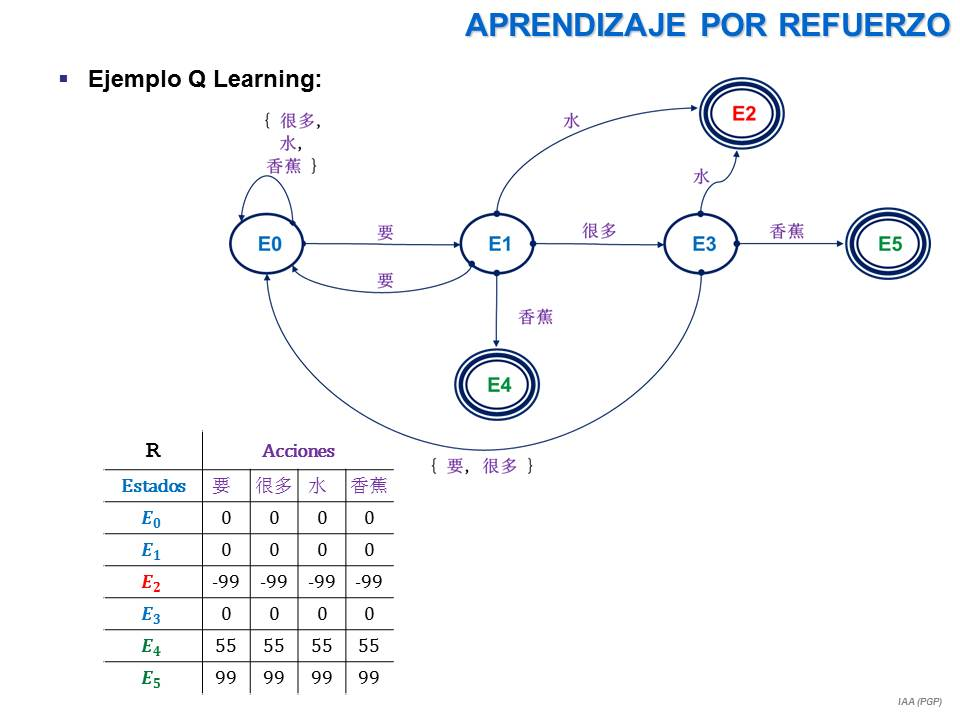


In [3]:
#@title Definir Entorno del Problema 

# variable auxiliar para determinar máximo de acciones a probar antes de abortar
MAX_ACCIONES_REALIZAR = 25
# variables auxiliares para determinar Acciones
posiblesAcciones = [ '要', '水', '香蕉', '很多' ]
posiblesAccionesDescrip = [ 'QUIERO', 'AGUA', 'BANANA', 'MUCHA' ]
# variables auxiliares para determinar Estados, con sus recompensas y sus transiciones posibles
# como a la recompensa lo penaliza la cantidad de iteraciones, 
#   en los estados finales se suma la cantidad mínima para que quede bien si es óptimo
matrizEstados = []
## E0
matrizEstados.append( { 'FINAL': False, 'REWARD': 0, '要' : 1, '水' : 0, '香蕉' : 0, '很多' : 0 } )
## E1
matrizEstados.append( { 'FINAL': False, 'REWARD': 0,  '要' : 0, '水' : 2, '香蕉' : 4, '很多' : 3 } )
## E2 (estado final)
matrizEstados.append( { 'FINAL': True, 'REWARD': (-99 + 1),  '要' : -1, '水' : -1, '香蕉' : -1, '很多' : -1 } )
## E3
matrizEstados.append( { 'FINAL': False, 'REWARD': 0, '要' : 0, '水' : 2, '香蕉' : 5, '很多' : 0 } )
## E4 (estado final)
matrizEstados.append( { 'FINAL': True, 'REWARD': (55 + 1), '要' : -1, '水' : -1, '香蕉' : -1, '很多' : -1 } )
## E5 (estado final)
matrizEstados.append( { 'FINAL': True, 'REWARD': (99 + 2), '要' : -1, '水' : -1, '香蕉' : -1, '很多' : -1 } )
posiblesEstadosDescrip = ['E{:}'.format(x) for x in range(0, len(matrizEstados))]

# Un entorno que represente el juego podría verse así:
class ExperimentoMonoEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=len(posiblesAcciones)-1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=0, name='observation')
    self._state = 0
    self._episode_ended = False

  def action_spec(self):
    # devuelve la forma de las acciones
    return self._action_spec

  def observation_spec(self):
    # devuelve la forma de las observaciones   
    return self._observation_spec

  def _reset(self):
    # resetea el entorno
    self._state = 0
    self._cantIteraciones = 0
    self._episode_ended = False
    return ts.restart(np.array([self._state], dtype=np.int32))

  def _step(self, action):
    # aplica una acción sobre el entorno
    
    if self._episode_ended:
      # si el entorno está finalizado, lo resetea
      return self.reset()
    
    if action < 0 or action > len(posiblesAcciones):
      raise ValueError("ID de acción inválida ", action,"!")

    # Aplica la acción correspondiente
    accionTipo = posiblesAcciones[action]
    if accionTipo in matrizEstados[self._state]:
        self._state = matrizEstados[self._state][accionTipo]
    else:      
      raise ValueError("Tipo de acción inválida: ", accionTipo,"!")

    # determina si debe finalizar o no
    if (self._state < 0) or (abs(self._cantIteraciones) >= abs(MAX_ACCIONES_REALIZAR)):
      # llegó a un estado inválido,
      # o si la cantidad de iteraciones llega al límite
      # fuerza que finaliza
      self._episode_ended = True
    else:
      # llegó a un estado final
      self._episode_ended =  matrizEstados[self._state]["FINAL"]

    if self._episode_ended:
      # si finaliza
      # devuelve el reward (siempre se maximiza)
      reward = matrizEstados[self._state]["REWARD"] + self._cantIteraciones
      return ts.termination(np.array([self._state], dtype=np.int32), reward)
    else:
      # si no finaliza
      self._cantIteraciones = self._cantIteraciones - 1
      return ts.transition(
          np.array([self._state], dtype=np.int32), reward=self._cantIteraciones, discount=0.9)

print("Entorno del Problema definido.")

# Definir entornos de entrenamiento y evaluación
train_py_env = ExperimentoMonoEnv()
eval_py_env = ExperimentoMonoEnv()

# Definir wrapper para convertir en entornos TF
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# define política al azar independiente del Agente
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

print("Entornos de entrenamiento y prueba definidos. ")

# definir simulador para probar el entorno
def SimularEntorno(eval_env, policy, titulo, mostarDetalleStep=False):
    print("\n** ", titulo, "**")                   
    # muesta estado inicial
    time_step = eval_env.reset()  
    ob = time_step.observation.numpy()[0]
    if mostarDetalleStep:
      print(" Ini: Estado ", posiblesEstadosDescrip[ob[0]], "[", time_step, "]")      
    else:
      print(" Ini: Estado ", posiblesEstadosDescrip[ob[0]])      
    j = 1
    secuenciaAcciones = ""
    while not time_step.is_last():
      # la política determina la acción a realizar
      action_step = policy.action( time_step )
      time_step = eval_env.step( action_step.action )
      # recupera la observación y muestra el nuevo estado
      ac = action_step.action.numpy()[0]
      ob = time_step.observation.numpy()[0]
      descAccion = "acción " + posiblesAcciones[ ac ] 
      if j > 1:
        secuenciaAcciones = secuenciaAcciones + " + "
      secuenciaAcciones = secuenciaAcciones + posiblesAccionesDescrip[ ac ]
      if mostarDetalleStep:
        print(" #", j, ": ", descAccion, "-> Estado ", posiblesEstadosDescrip[ob[0]], "[", time_step, "]")
      else:
        print(" #", j, ": ", descAccion, "-> Estado ", posiblesEstadosDescrip[ob[0]])
      j = j + 1

    # muestra estado final
    ob = time_step.observation.numpy()[0]
    r = time_step.reward.numpy()
    if mostarDetalleStep:
      print(" Fin -> Estado ", posiblesEstadosDescrip[ob[0]], "[", time_step, "]")
    else:
      print(" Fin -> Estado ", posiblesEstadosDescrip[ob[0]])
    print(" Secuencia de Acciones = ", secuenciaAcciones)
    print(' Recompensa Final = ', r[0])
    return r[0]


# función auxiliar para comparar
def compararRtdosPolicy(cantidad_probar, eval_env, policy1, policy2, descPol1="Agente 1", descPol2="Agente 2"):
  prom1 = 0
  prom2 = 0
  for i in range(cantidad_probar):
    print("\n> Prueba ", i+1, ":")
    # Probar 1
    valor1 = SimularEntorno(eval_env, policy1, "Resultados de " + descPol1, False) 
    prom1 = prom1 + valor1
    # Probar 2
    valor2 = SimularEntorno(eval_env, policy2, "Resultados de " + descPol2, False) 
    prom2 = prom2 + valor2
    # Decide Ganador
    strMostrar = "\n--> " + descPol1 + " (%s) genera" % valor1
    if valor1 > valor2:
      strMostrar = strMostrar + " MEJOR "
    elif valor1 < valor2:
      strMostrar = strMostrar + " PEOR "
    else:
      strMostrar = strMostrar + " IGUAL "
    strMostrar = strMostrar + "resultado que " + descPol2 + " (%s)." % valor2
    print(strMostrar)
  # Decide Ganador General
  if cantidad_probar > 0:
    prom1 = prom1 / cantidad_probar
    prom2 = prom2 / cantidad_probar
    print("\n================================================================================================\n")
    strMostrar = " * En Promedio " + descPol1 + " (%s) genera" % prom1
    if prom1 > prom2:
      strMostrar = strMostrar + " MEJORES "
    elif prom1 < prom2:
      strMostrar = strMostrar + " PEORES "
    else:
      strMostrar = strMostrar + " IGUALES "
    strMostrar = strMostrar + "resultados que " + descPol2 + " (%s)." % prom2
    print(strMostrar)
    print("\n================================================================================================\n")

print("Simulador del entorno definido.")

# Probar el entorno definido con Política Aleatoria (opcional)
Probar_Entorno = True #@param {type:"boolean"}
MostarDetalleSteps = False #@param {type:"boolean"}

if Probar_Entorno:
  SimularEntorno(eval_env, random_policy, "Probando el entorno del problema al azar", MostarDetalleSteps)

Entorno del Problema definido.
Entornos de entrenamiento y prueba definidos. 
Simulador del entorno definido.

**  Probando el entorno del problema al azar **
 Ini: Estado  E0
 # 1 :  acción 香蕉 -> Estado  E0
 # 2 :  acción 水 -> Estado  E0
 # 3 :  acción 水 -> Estado  E0
 # 4 :  acción 很多 -> Estado  E0
 # 5 :  acción 水 -> Estado  E0
 # 6 :  acción 水 -> Estado  E0
 # 7 :  acción 要 -> Estado  E1
 # 8 :  acción 要 -> Estado  E0
 # 9 :  acción 要 -> Estado  E1
 # 10 :  acción 要 -> Estado  E0
 # 11 :  acción 水 -> Estado  E0
 # 12 :  acción 水 -> Estado  E0
 # 13 :  acción 香蕉 -> Estado  E0
 # 14 :  acción 很多 -> Estado  E0
 # 15 :  acción 要 -> Estado  E1
 # 16 :  acción 香蕉 -> Estado  E4
 Fin -> Estado  E4
 Secuencia de Acciones =  BANANA + AGUA + AGUA + MUCHA + AGUA + AGUA + QUIERO + QUIERO + QUIERO + QUIERO + AGUA + AGUA + BANANA + MUCHA + QUIERO + BANANA
 Recompensa Final =  41.0


##Q-Learning

In [4]:
#@title Define clase auxiliar Policy para Q-Learning

## funciones auxiliares basadas en:
##  https://rubikscode.net/2019/06/24/introduction-to-q-learning-with-python-and-open-ai-gym/

from tf_agents.policies.fixed_policy import FixedPolicy
from tf_agents.trajectories import policy_step
from tf_agents.utils import nest_utils
from tf_agents.specs import tensor_spec
from tf_agents.typing import types
from typing import Optional, Text

## funciones auxiliares para manejar TS->Obs
## (se puede definir otras si es necesario)

# devuelve el primer valor de OBS 
# como número de estado
def obtenerEstadoDeObs(obs):  
  return obs[0]

# devuelve valor unico en base a vector OBS 
# para determinar fila de estado
def generarNroEstadoVector(obs):
  ntarget = np.array(obs).flatten()
  valorTotal = 0        
  for i in range(1, len(ntarget)):
    if ntarget[i] == -1:
      valorTotal = valorTotal + 2**i    
    elif ntarget[i] == 1:
      valorTotal = valorTotal + 3**i      
  return valorTotal

# devuelve la cantidad de estados máxima
# que se pueden generar usando un ejemplo 
# del vector de OBS 
def calcMaxNroEstadoVector(ejemploObs):
  ntarget = np.array(ejemploObs).flatten()  
  cant = len(ntarget)
  return ( 3**cant + 2**cant + 1 )


# Clase para Q-Learning
# (se hereda de FixedPolicy porque es una simple para tener como base)
class QL_TF_Policy(FixedPolicy):
    
  def __init__(self,
               posiblesEstadosList, 
               posiblesAccionesList,
               time_step_spec: ts.TimeStep,            
               action_spec: types.NestedTensorSpec,                              
               funcDevuelveNroEstado = obtenerEstadoDeObs,   
               policy_info: types.NestedTensorSpec = (),
               info_spec: types.NestedTensorSpec = (),
               name: Optional[Text] = None):    
    
      # llama al padre
      super(FixedPolicy, self).__init__(time_step_spec, action_spec, clip=False,
                                      info_spec=info_spec,
                                      name=name,
                                      emit_log_probability=False)             
      # guarda valores auxiliares
      self._policy_info = policy_info
      self._time_step_spec = tensor_spec.from_spec(time_step_spec)
      self._action_spec = tensor_spec.from_spec(action_spec)   
      self._funcDevuelveNroEstado = funcDevuelveNroEstado
      # inicializa parametros de matriz
      if (posiblesEstadosList is None) or (len(posiblesEstadosList)<2):
       raise ValueError('No se ha definida la lista de posibles estdos!' )
      self._posiblesEstadosList = posiblesEstadosList
      self._cantEstados = len(posiblesEstadosList)
      if (posiblesAccionesList is None) or (len(posiblesAccionesList)<2):
       raise ValueError('No se ha definida la lista de posibles acciones!' )
      self._posiblesAccionesList = posiblesAccionesList
      self._cantAcciones = len(posiblesAccionesList)
      self.ResetQ()
  
  # funcion auxiliar para inicializar la matriz
  def ResetQ(self):     
      self._Qtable = np.zeros([self._cantEstados, self._cantAcciones])
      self._QtableEntrenada = False 

  # función auxiliar de entrenamiento
  def TrainQ(self, env, train_policy, alpha = 0.1, gamma = 0.6, epsilon = 0.1, cant_ciclos_entrenamiento = 100000, log_cada_ciclos = 1000, mostrarDetalleAcciones=False):
      ##print(self._Qtable.shape)
      ##print(self._usarOBSVector)
      # ejecuta el entrenamiento
      for step in range(1, cant_ciclos_entrenamiento+1):
          # Resetea el enviroment
          time_step = env.reset()  
          ob = time_step.observation.numpy()[0]
          state = self._funcDevuelveNroEstado(ob)
          secuenciaAcciones = ""
          j = 1
          # Simula      
          while not time_step.is_last():
              # Considera lo aprendido o toma al azar depende de azar y epsilon
              if random.uniform(0, 1) < epsilon:
                  # toma de Matriz-Q
                  accionAplicar = np.argmax( self._Qtable[state] )              
              else:
                  # toma al azar
                  action_step = train_policy.action( time_step ) 
                  accionAplicar = action_step.action.numpy()[0]
              if j > 1:
                secuenciaAcciones = secuenciaAcciones + " + "
              secuenciaAcciones = secuenciaAcciones + self._posiblesAccionesList[ accionAplicar ]	
              j = j + 1
              # Aplica la Accion  
              time_step = env.step( accionAplicar )
              ob = time_step.observation.numpy()[0]
              next_state = self._funcDevuelveNroEstado(ob)
              r = time_step.reward.numpy()[0] 
              # Recalcula Q
              q_value = self._Qtable[state, accionAplicar]
              max_value = np.max(self._Qtable[next_state])
              new_q_value = (1 - alpha) * q_value + alpha * (r + gamma * max_value)                       
              # Actualiza Matriz-Q
              self._Qtable[state, accionAplicar] = new_q_value
              state = next_state        
          # muestra estado
          if log_cada_ciclos > 0:
            if (step == 1) or (step % log_cada_ciclos == 0):
              if mostrarDetalleAcciones:
                print('step = {0}: Recompensa = {1} - Acciones({2}) = {3} '.format(step, r, (j-1), secuenciaAcciones))  
              else:
                print('step = {0}: Recompensa = {1} - Acciones({2}) '.format(step, r, (j-1)))  
      # Devuelve Matriz-Q
      self._QtableEntrenada = True
      return self._Qtable   

  # obtiene Q-Table como DataFrame
  def getQ_DF(self):
        cm = self._Qtable 
        cmtx = pd.DataFrame(
            cm, 
            index=self._posiblesEstadosList, 
            columns=self._posiblesAccionesList
          )
        return cmtx

  # graba Q-Table como CSV
  def saveQ(self, fileName):
        # obtiene data frame de matriz Q
        df = self.getQ_DF()
        # graba matriz Q como CSV
        df.to_csv(fileName, index=True)
        return 

  # recupera Q-Table de  CSV
  def loadQ(self, fileName):
        # lee matriz Q de CSV
        df = pd.read_csv(fileName)         
        # carga elementos en memoria
          # saca nombre de estados
        self._posiblesEstadosList = list(df.pop(df.columns[0]))  
          # acciones
        self._posiblesAccionesList = list(df.columns.tolist())
          # borra el primer elemento de titulo
        ##self._posiblesAccionesList = np.delete(self._posiblesAccionesList, 0, axis=0)      
         # matriz Q
        self._Qtable = list(df.to_numpy())
        # re-inicializa las cantidades
        self._cantEstados = len(self._posiblesEstadosList)
        self._cantAcciones = len(self._posiblesAccionesList)
        self._QtableEntrenada = True
        # muestra resultados
        self.MostrarQ("Matriz-Q recuperada:")
        return 

  # función auxiliar para mostrar matri Q
  def MostrarQ(self, titulo="Matriz-Q entrenada:"):
        # muestra Q table
        cmtx = self.getQ_DF()
        print('\n ' + titulo + ' ')        
        # agrega para poder mostrar la matrix de confusión completa
        pd.options.display.max_rows = 100
        pd.options.display.max_columns = 100
        print(cmtx)
        print("\n")
        return 

  # devuelve la accion que se debe aplicar usando la matrix Q entrenada
  def _action(self, time_step, policy_state, seed):    
      # determina la accion a realizar
      # obtiene estado actual
      ob = time_step.observation.numpy()[0]
      state = self._funcDevuelveNroEstado(ob)
      # toma de Matriz-Q      
      accionAplicar = np.argmax( self._Qtable[state] )
      # formatea el valor a devolver usando la action_spec y time_step_spec
      def convert(action, spec):
        return tf.convert_to_tensor(value=action, dtype=spec.dtype)
      self._action_value = tf.nest.map_structure(convert, accionAplicar,
                                                  self._action_spec)
      outer_shape = nest_utils.get_outer_shape(time_step, self._time_step_spec)
      action = tf.nest.map_structure(lambda t: common.replicate(t, outer_shape),
                                   self._action_value)
      # devuelve la accion
      return policy_step.PolicyStep(action, policy_state, self._policy_info)


print("Clase QL_TF_Policy creada.")

Clase QL_TF_Policy creada.


In [5]:
#@title Entrenar con algoritmo Q-Learning

# parámetros
entrenar_QL = True #@param {type:"boolean"}
alpha = 0.1 #@param {type:"number"}
gamma = 0.8 #@param {type:"number"}
epsilon = 0.4 #@param {type:"number"}
cant_ciclos_entrenamiento_finalizar = 2000 #@param {type:"integer"}
mostar_recompensa_cada = 200  #@param {type:"integer"}
if alpha <= 0.0:
   alpha = 0.001
if gamma <= 0.0:
    gamma = 0.001
if epsilon <= 0.0:
   epsilon = 0.001    
if cant_ciclos_entrenamiento_finalizar <= 10:
   cant_ciclos_entrenamiento_finalizar = 10    
if mostar_recompensa_cada < 1:
  mostar_recompensa_cada = 1

# instancia política de Q Learning
ql_policy = QL_TF_Policy(posiblesEstadosList = posiblesEstadosDescrip,
                         posiblesAccionesList = posiblesAccionesDescrip,                         
                         time_step_spec = train_env.time_step_spec(),
                         action_spec = train_env.action_spec(),
                         funcDevuelveNroEstado = obtenerEstadoDeObs
                         )

if entrenar_QL:
  # hace el entrenamiento
  print("** Comienza el Entrenamiento:\n")
  ql_policy.TrainQ(env = train_env, 
                   train_policy = random_policy, 
                   alpha = alpha, gamma = gamma, epsilon = epsilon, 
                   cant_ciclos_entrenamiento = cant_ciclos_entrenamiento_finalizar, 
                   log_cada_ciclos = mostar_recompensa_cada,
                   mostrarDetalleAcciones = True)
  print("\n** Entrenamiento Finalizado **")
  # muestra matriz
  ql_policy.MostrarQ()
else:
  print("No se ejecuta entrenamiento de Agente Q-Learning.")  

** Comienza el Entrenamiento:

step = 1: Recompensa = -99.0 - Acciones(2) = QUIERO + AGUA 
step = 200: Recompensa = -101.0 - Acciones(4) = AGUA + QUIERO + MUCHA + AGUA 
step = 400: Recompensa = 99.0 - Acciones(3) = QUIERO + MUCHA + BANANA 
step = 600: Recompensa = 55.0 - Acciones(2) = QUIERO + BANANA 
step = 800: Recompensa = -99.0 - Acciones(2) = QUIERO + AGUA 
step = 1000: Recompensa = 98.0 - Acciones(4) = BANANA + QUIERO + MUCHA + BANANA 
step = 1200: Recompensa = 95.0 - Acciones(7) = MUCHA + AGUA + MUCHA + MUCHA + QUIERO + MUCHA + BANANA 
step = 1400: Recompensa = -103.0 - Acciones(6) = BANANA + BANANA + AGUA + QUIERO + MUCHA + AGUA 
step = 1600: Recompensa = 99.0 - Acciones(3) = QUIERO + MUCHA + BANANA 
step = 1800: Recompensa = -99.0 - Acciones(2) = QUIERO + AGUA 
step = 2000: Recompensa = 54.0 - Acciones(3) = AGUA + QUIERO + BANANA 

** Entrenamiento Finalizado **

 Matriz-Q entrenada: 
       QUIERO        AGUA     BANANA      MUCHA
E0  55.085015   39.992792  40.601078  40.0013

In [6]:
#@title Probar Q-Learning Entrenado contra el Azar
cantidad_probar = 5 # @param {type:"integer"}

if ql_policy._QtableEntrenada:
  compararRtdosPolicy(cantidad_probar, eval_env, ql_policy, random_policy, "Agente Q-Learning entrenado", "el Azar")



> Prueba  1 :

**  Resultados de Agente Q-Learning entrenado **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado  E5
 Secuencia de Acciones =  QUIERO + MUCHA + BANANA
 Recompensa Final =  99.0

**  Resultados de el Azar **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 水 -> Estado  E2
 Fin -> Estado  E2
 Secuencia de Acciones =  QUIERO + MUCHA + AGUA
 Recompensa Final =  -100.0

--> Agente Q-Learning entrenado (99.0) genera MEJOR resultado que el Azar (-100.0).

> Prueba  2 :

**  Resultados de Agente Q-Learning entrenado **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado  E5
 Secuencia de Acciones =  QUIERO + MUCHA + BANANA
 Recompensa Final =  99.0

**  Resultados de el Azar **
 Ini: Estado  E0
 # 1 :  acción 香蕉 -> Estado  E0
 # 2 :  acción 要 -> Estado  E1
 # 3 :  acción 水 -> Estad

##DQN

In [7]:
#@title Definir el Agente tipo DQN
entrenar_DQN = True # @param {type:"boolean"}
DQNpolicy = None

if entrenar_DQN:
  # agente categorical oculto por ahora (problemas en librería)
  tipo_agente = "DQN" #param ["DQN", "DQN Categorico (C51)"]
  learning_rate = 1e-3  # @param {type:"number"}
  cant_neuronas_ocultas = "100, 50" # @param {type:"string"}
  DQNCat_num_atoms = 51  #param {type:"integer"}

  # controla cantidad de atoms para DQN Cat
  if DQNCat_num_atoms <= 1:
    DQNCat_num_atoms = 51

  #define las capas convolutional
  CNN_preprocessing_layers = None

  # Define cantidad de neuronas ocultas para RNA-Q
  hidden_layers = []
  for val in cant_neuronas_ocultas.split(','):
    if  int(val) < 1:
      hidden_layers.append( 10 )
    else:
      hidden_layers.append( int(val) )
  fc_layer_params = tuple(hidden_layers, )
  #print(fc_layer_params)

  if tipo_agente=="DQN":

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    train_step_counter = tf.Variable(0)

    # Define RNA-Q
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        fc_layer_params=fc_layer_params)

    # Define el agente de tipo Q
    ag = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

    ag.initialize()

    print("Agente DQN inicializado. ")

  elif tipo_agente == "DQN Categorico (C51)":
    
    # Define RNA-Q Categórico
    categorical_q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=DQNCat_num_atoms,
        fc_layer_params=fc_layer_params)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.compat.v2.Variable(0)
    
    # parámetros especificos (por defecto)
    n_step_update = 2
    gamma = 0.99

    # Define el agente de tipo Q Categórico
    ag = CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        categorical_q_network=categorical_q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        td_errors_loss_fn=common.element_wise_squared_loss,
        gamma=gamma,
        train_step_counter=train_step_counter)
    
    ag.initialize()
    
    print("Agente DQN Categorico (C51) inicializado. ")
else:
  print("No se ejecuta entrenamiento de Agente DQN.")  

Agente DQN inicializado. 


In [8]:
#@title Métricas para evaluación y Preparar datos para Entrenamiento del Agente DQN

if entrenar_DQN:

  # parámetros
  initial_collect_steps = 100  # @param {type:"integer"} 
  collect_steps_per_iteration = 10# @param {type:"integer"}
  replay_buffer_max_length = 100000  # @param {type:"integer"}
  batch_size = 64  # @param {type:"integer"}
  num_eval_episodes = 10  # @param {type:"integer"}

  # Definir Métricas para evaluación para Agente DQN
    
  #eval_policy = ag.policy
  #collect_policy = ag.collect_policy
  #time_step = train_env.reset()

  # Se usa el promedio de la recompensa (la más común)
  # See also the metrics module for standard implementations of different metrics.
  # https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

  def compute_avg_return(environment, policy, num_episodes=10):
    if num_episodes == 0:
        return 0.0 
    total_return = 0.0
    for _ in range(num_episodes):

      time_step = environment.reset()
      episode_return = 0.0

      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_return += time_step.reward
      total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

  ##compute_avg_return(eval_env, random_policy, num_eval_episodes)

  # Define 'Replay Buffer' para que el agente recuerde las observaciones realizadas

  table_name = 'uniform_table'
  replay_buffer_signature = tensor_spec.from_spec(
        ag.collect_data_spec)
  replay_buffer_signature = tensor_spec.add_outer_dim(
      replay_buffer_signature)

  table = reverb.Table(
      table_name,
      max_size=replay_buffer_max_length,
      sampler=reverb.selectors.Uniform(),
      remover=reverb.selectors.Fifo(),
      rate_limiter=reverb.rate_limiters.MinSize(1),
      signature=replay_buffer_signature)

  reverb_server = reverb.Server([table])

  replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
      ag.collect_data_spec,
      table_name=table_name,
      sequence_length=2,
      local_server=reverb_server)

  rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2)      

  print("\nDatos recolectados.")

  # Dataset generates trajectories with shape [Bx2x...]
  dataset = replay_buffer.as_dataset(
      num_parallel_calls=3,
      sample_batch_size=batch_size,
      num_steps=2).prefetch(3)
  iterator = iter(dataset)
  
  print("\nDataset creado para datos recolectadso.")

else:
  print("No se ejecuta entrenamiento de Agente DQN.")  


Datos recolectados.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089



Dataset creado para datos recolectadso.


In [9]:
#@title Entrenar al Agente DQN

if entrenar_DQN:

  cant_ciclos_entrenamiento_finalizar = 10000# @param {type:"integer"}
  log_cada_ciclos = 200  # @param {type:"integer"}
  mostar_recompensa_cada = 500  # @param {type:"integer"}
  cant_episodios_evaluacion =  10# @param {type:"integer"}
  minima_recompensa_promedio_finalizar = 95.0 # @param {type:"number"}
  
  # (Optional) Optimize by wrapping some of the code in a graph using TF function.
  ag.train = common.function(ag.train)

  # Reset the train step.
  ag.train_step_counter.assign(0)

  # Evaluate the agent's policy once before training.  
  avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
  ar_cicloL = []
  ar_cicloR = []
  ar_returns = []
  ar_loss = []

  # Reset the environment.
  time_step = train_py_env.reset()

  # Create a driver to collect experience.
  collect_driver = py_driver.PyDriver(
      train_py_env,
      py_tf_eager_policy.PyTFEagerPolicy(
        ag.collect_policy, use_tf_function=True),
      [rb_observer],
      max_steps=collect_steps_per_iteration)

  print("\n** Comienza el Entrenamiento **\n")
  for _ in range(cant_ciclos_entrenamiento_finalizar):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = ag.train(experience).loss

    step = ag.train_step_counter.numpy()    

    if (step == 1) or (step == cant_ciclos_entrenamiento_finalizar) or (step % log_cada_ciclos == 0):
      print('step = {0}: loss = {1:.3f}'.format(step, train_loss))    
      ar_cicloL.append( step )
      ar_loss.append( train_loss )
    
    if (step == 1) or (step == cant_ciclos_entrenamiento_finalizar) or (step % mostar_recompensa_cada == 0):
      avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
      ar_cicloR.append( step )
      ar_returns.append( avg_return )
      print('step = {0}: Promedio Recompensa = {1:.1f}'.format(step, avg_return))

      if (avg_return >= minima_recompensa_promedio_finalizar):
        print('** Finaliza en step {0} por buen valor de recompensa promedio: {1:.1f}'.format(step, avg_return)) 
        break

  DQNpolicy = ag.policy
  print("\n** Entrenamiento Finalizado **\n")
else:
  print("No se ejecuta entrenamiento de Agente DQN.")  


** Comienza el Entrenamiento **



Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 1: loss = 932.729
step = 1: Promedio Recompensa = -350.0
step = 200: loss = 750.799
step = 400: loss = 224.878
step = 500: Promedio Recompensa = 54.0
step = 600: loss = 223.018
step = 800: loss = 102.847
step = 1000: loss = 104.515
step = 1000: Promedio Recompensa = 96.0
** Finaliza en step 1000 por buen valor de recompensa promedio: 96.0

** Entrenamiento Finalizado **



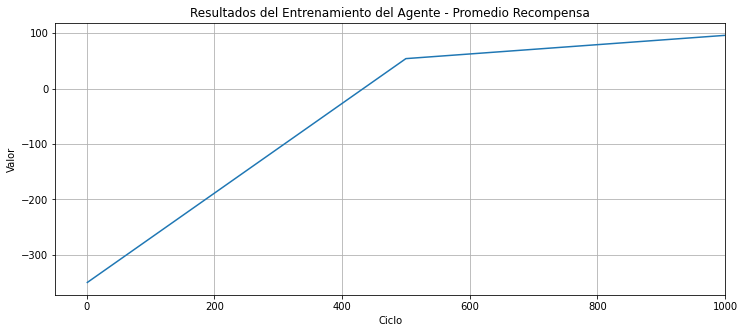

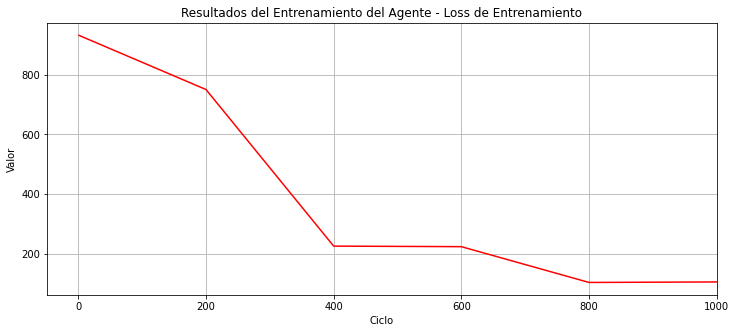

In [10]:
#@title Mostrar Gráficos del Entrenamiento del Agente DQN

if entrenar_DQN:

  plt.figure(figsize=(12,5)) 
  plt.plot( ar_cicloR, ar_returns)
  plt.title("Resultados del Entrenamiento del Agente - Promedio Recompensa")
  #plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
  plt.ylabel('Valor')
  plt.xlabel('Ciclo')
  plt.xlim(right=max(ar_cicloR))   
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(12,5)) 
  #plt.plot( ar_ciclo, ar_returns)
  plt.plot( ar_cicloL, ar_loss, color="red" )
  plt.title("Resultados del Entrenamiento del Agente - Loss de Entrenamiento")
  #plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
  plt.ylabel('Valor')
  plt.xlabel('Ciclo')
  plt.xlim(right=max(ar_cicloL))   
  plt.grid(True)
  plt.show()


In [11]:
#@title Probar el Agente DQN Entrenado contra el Azar
cantidad_probar = 5 # @param {type:"integer"}

if DQNpolicy is not None:
  compararRtdosPolicy(cantidad_probar, eval_env, DQNpolicy, random_policy, "Agente DQN entrenado", "el Azar")



> Prueba  1 :

**  Resultados de Agente DQN entrenado **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado  E5
 Secuencia de Acciones =  QUIERO + MUCHA + BANANA
 Recompensa Final =  99.0

**  Resultados de el Azar **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 水 -> Estado  E2
 Fin -> Estado  E2
 Secuencia de Acciones =  QUIERO + AGUA
 Recompensa Final =  -99.0

--> Agente DQN entrenado (99.0) genera MEJOR resultado que el Azar (-99.0).

> Prueba  2 :

**  Resultados de Agente DQN entrenado **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado  E5
 Secuencia de Acciones =  QUIERO + MUCHA + BANANA
 Recompensa Final =  99.0

**  Resultados de el Azar **
 Ini: Estado  E0
 # 1 :  acción 水 -> Estado  E0
 # 2 :  acción 香蕉 -> Estado  E0
 # 3 :  acción 很多 -> Estado  E0
 # 4 :  acción 香蕉 -> Estado  E0
 # 5 :  acción 要 -> Esta

## Comparar Q-Learning y DQN

In [14]:



#@title Cargar o Guardar los Agentes Q-Learning y DQN entrenados

# parámetros
directorio_modelo = '/content/gdrive/MyDrive/IA/demoRL/Modelos' #@param {type:"string"}
nombre_modelo_grabar = "policy-MONO" #@param {type:"string"}
accion_realizar = "-" #@param ["-", "Cargar Modelo", "Grabar Modelo"]

if accion_realizar != "-":
  import os
  from google.colab import drive
  from tf_agents.policies import TFPolicy, policy_saver
  # determina lugar donde se guarda el modelo
  policy_dir = os.path.join(directorio_modelo, nombre_modelo_grabar)
  qlCSV = policy_dir + "/QM-QLearning.csv"
  # Montar Drive
  drive.mount('/content/gdrive')
if accion_realizar == "Grabar Modelo":
  if (DQNpolicy is not None) and isinstance(DQNpolicy, TFPolicy):
    # guarda la politica del agente DQN entrenado
    tf_policy_saver = policy_saver.PolicySaver(DQNpolicy)
    tf_policy_saver.save(policy_dir)
    print("\nPolítica DQN guardada en ", policy_dir)
  if ql_policy is not None:
    if not os.path.exists(policy_dir):
         os.makedirs(policy_dir)
    ql_policy.saveQ(qlCSV)
    print("\nPolítica Q-Learning guardada en ", qlCSV)
elif accion_realizar == "Cargar Modelo":
  # carga la política del modelo
  DQNpolicy = tf.compat.v2.saved_model.load(policy_dir)
  print("\nPolítica DQN recuperada de ", policy_dir)
  ql_policy.loadQ(qlCSV)
  print("\nPolítica Q-Learning recuperada de ", qlCSV)


Mounted at /content/gdrive


/usr/local/lib/python3.9/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:521: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "



Política DQN guardada en  /content/gdrive/MyDrive/IA/demoRL/Modelos/policy-MONO

Política Q-Learning guardada en  /content/gdrive/MyDrive/IA/demoRL/Modelos/policy-MONO/QM-QLearning.csv


In [13]:
#@title Probar Q-Learning Entrenado contra Agente DQN Entrenado
cantidad_probar = 10 # @param {type:"integer"}

if DQNpolicy is not None and ql_policy._QtableEntrenada:
  compararRtdosPolicy(cantidad_probar, eval_env, DQNpolicy, ql_policy, "Agente DQN", "Agente Q-Learning")



> Prueba  1 :

**  Resultados de Agente DQN **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado  E5
 Secuencia de Acciones =  QUIERO + MUCHA + BANANA
 Recompensa Final =  99.0

**  Resultados de Agente Q-Learning **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado  E5
 Secuencia de Acciones =  QUIERO + MUCHA + BANANA
 Recompensa Final =  99.0

--> Agente DQN (99.0) genera IGUAL resultado que Agente Q-Learning (99.0).

> Prueba  2 :

**  Resultados de Agente DQN **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado  E5
 Secuencia de Acciones =  QUIERO + MUCHA + BANANA
 Recompensa Final =  99.0

**  Resultados de Agente Q-Learning **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado 